# Lab -- Dataset Curation with Multiple Annotators

This notebook contains exercises to analyze an existing classification dataset labeled by multiple annotators (e.g. collected via crowdsourcing).

You may find it helpful to first install the following dependencies:

In [2]:
!pip install cleanlab
# We originally used the version: cleanlab==2.2.0
# This automatically installs other required packages like numpy, pandas, sklearn

In [3]:
import numpy as np
import pandas as pd

## Analyzing dataset labeled by multiple annotators

We simulate a small classification dataset (3 classes, 2-dimensional features) with ground truth labels that are then hidden from our analysis. The analysis is conducted on labels from noisy annotators whose labels are derived from the ground truth labels, but with some probability of error in each annotated label where the probability is determined by the underlying quality of the annotator. In subsequent exercises, you should assume the ground truth labels and the true annotator qualities are unknown to you.

In [4]:
## You don't need to understand this cell, it's just used for generating the dataset

SEED = 123  # for reproducibility
np.random.seed(seed=SEED)

def make_data(sample_size = 300):
    """ Produce a 3-class classification dataset with 2-dimensional features and multiple noisy annotations per example. """
    num_annotators=50  # total number of data annotators
    class_frequencies = [0.5, 0.25, 0.25]
    sizes=[int(np.ceil(freq*sample_size)) for freq in class_frequencies]  # number of examples belonging to each class
    good_annotator_quality = 0.6
    bad_annotator_quality = 0.3
    
    # Underlying statistics of the datset (unknown to you)
    means=[[3, 2], [7, 7], [0, 8]]
    covs=[[[5, -1.5], [-1.5, 1]], [[1, 0.5], [0.5, 4]], [[5, 1], [1, 5]]]
    
    m = len(means)  # number of classes
    n = sum(sizes)
    local_data = []
    labels = []

    # Generate features and true labels
    for idx in range(m):
        local_data.append(
            np.random.multivariate_normal(mean=means[idx], cov=covs[idx], size=sizes[idx])
        )
        labels.append(np.array([idx for i in range(sizes[idx])]))
    X_train = np.vstack(local_data)
    true_labels_train = np.hstack(labels)

    # Generate noisy labels from each annotator
    s = pd.DataFrame(
        np.vstack(
            [
                generate_noisy_labels(true_labels_train, good_annotator_quality)
                if i < num_annotators - 10  # last 10 annotators are worse
                else generate_noisy_labels(true_labels_train, bad_annotator_quality)
                for i in range(num_annotators)
            ]
        ).transpose()
    )

    # Each annotator only labels approximately 10% of the dataset (unlabeled points represented with NaN)
    s = s.apply(lambda x: x.mask(np.random.random(n) < 0.9)).astype("Int64")
    s.dropna(axis=1, how="all", inplace=True)
    s.columns = ["A" + str(i).zfill(4) for i in range(1, num_annotators+1)]
    # Drop rows not annotated by anybody
    row_NA_check = pd.notna(s).any(axis=1)
    X_train = X_train[row_NA_check]
    true_labels_train = true_labels_train[row_NA_check]
    multiannotator_labels = s[row_NA_check].reset_index(drop=True)
    # Shuffle the rows of the dataset
    shuffled_indices = np.random.permutation(len(X_train))
    return {
        "X_train": X_train[shuffled_indices],
        "true_labels_train": true_labels_train[shuffled_indices],
        "multiannotator_labels": multiannotator_labels.iloc[shuffled_indices],
    }

def generate_noisy_labels(true_labels, annotator_quality):
    """ Randomly flips each true label to a different class with probability that depends on annotator_quality. """
    n = len(true_labels)
    m = np.max(true_labels) + 1  # number of classes
    annotated_labels = np.random.randint(low=0, high=3, size=n)
    correctly_labeled_indices = np.random.random(n) < annotator_quality
    annotated_labels[correctly_labeled_indices] = true_labels[correctly_labeled_indices]
    return annotated_labels

In [5]:
data_dict = make_data(sample_size = 300)

X = data_dict["X_train"]
multiannotator_labels = data_dict["multiannotator_labels"]
true_labels = data_dict["true_labels_train"] # used for comparing the accuracy of consensus labels

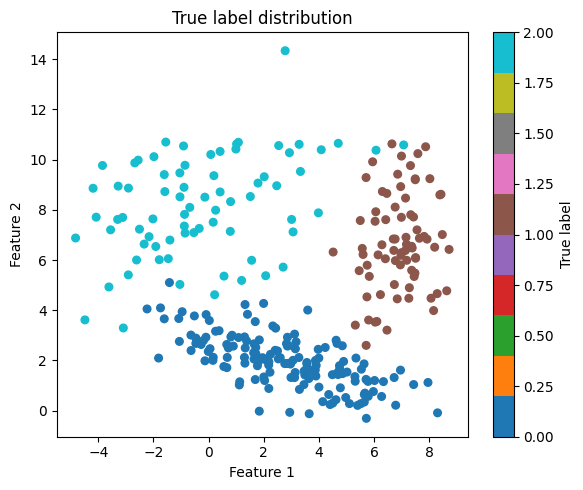

In [6]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
scatter = plt.scatter(X[:, 0], X[:, 1], c=true_labels, cmap="tab10", s=30)
plt.xlabel("Feature 1")
plt.ylabel("Feature 2")
plt.title("True label distribution")
plt.colorbar(scatter, label="True label")
plt.tight_layout()
plt.show()

Let's view the first few rows of the data used for this exercise. Here are the labels selected by each annotator for the first few examples. Here each example is a row, and the annotators are columns. Not all annotators labeled each example; valid class annotations from those that did label the example are integers (either 0, 1, or 2 for our 3 classes), and otherwise the annotation is left as `NA` if a particular annotator did not label a particular example.

In [7]:
multiannotator_labels.head()

,A0001,A0002,A0003,A0004,A0005,A0006,A0007,A0008,A0009,A0010,...,A0041,A0042,A0043,A0044,A0045,A0046,A0047,A0048,A0049,A0050
247,<NA>,2,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
290,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
262,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,2,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
182,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>
143,<NA>,<NA>,0,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,...,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>,<NA>


Here are the corresponding 2D data features for these examples:

In [8]:
X[:5]

array([[ 1.01592896, 10.62213634],
       [-1.91393643,  6.53944268],
       [ 0.55962291,  5.35885902],
       [ 6.73677377,  5.02311322],
       [ 6.95949986,  1.61434817]])

### Train model with cross-validation

In this exercise, we consider the simple K Nearest Neighbors classification model, which produces predicted class probabilities for a particular example via a (weighted) average of the labels of the K closest examples. We will train this model via cross-validation and use it to produce held-out predictions for each example in our dataset.

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict

def train_model(labels_to_fit):
    """ Trains a simple feedforward neural network model on the data features X with y = labels_to_fit, via cross-validation.
        Returns out-of-sample predicted class probabilities for each example in the dataset
        (from a copy of model that was never trained on this example).
        Also evaluates the held-out class predictions against ground truth labels.
    """
    num_crossval_folds = 10  # number of folds of cross-validation
    # model = MLPClassifier(max_iter=1000, random_state=SEED)
    model = KNeighborsClassifier(weights="distance")
    pred_probs = cross_val_predict(
        estimator=model, X=X, y=labels_to_fit, cv=num_crossval_folds, method="predict_proba"
    )
    class_predictions = np.argmax(pred_probs, axis=1)
    held_out_accuracy = np.mean(class_predictions == true_labels)
    print(f"Accuracy of held-out model predictions against ground truth labels: {held_out_accuracy}")
    return pred_probs

Here we demonstrate how to train and evaluate this model. Note that the evaluation is against ground truth labels, which you wouldn't have in real applications, so this evaluation is just for demonstration purposes. We'll first fit this model using labels comprised of one randomly selected annotation for each example.

In [10]:
labels_from_random_annotators = true_labels.copy()
for i in range(len(multiannotator_labels)):
    annotations_for_example_i = multiannotator_labels.iloc[i][pd.notna(multiannotator_labels.iloc[i])]
    labels_from_random_annotators[i] = np.random.choice(annotations_for_example_i.values)

print(f"Accuracy of random annotators' labels against ground truth labels: {np.mean(labels_from_random_annotators == true_labels)}")
pred_probs_from_model_fit_to_random_annotators = train_model(labels_to_fit = labels_from_random_annotators)


Accuracy of random annotators' labels against ground truth labels: 0.6822742474916388
Accuracy of held-out model predictions against ground truth labels: 0.7993311036789298


We can also fit this model using the ground truth labels (which you would not be able to in practice), just to see how good it could be:

In [11]:
pred_probs_from_unrealistic_model_fit_to_true_labels = train_model(labels_to_fit = true_labels)

Accuracy of held-out model predictions against ground truth labels: 0.9732441471571907


## Exercise 1

Compute majority-vote consensus labels for each example from the data in `multiannotator_labels`. Think about how to best break ties!

- Evaluate the accuracy of these majority-vote consensus labels against the ground truth labels.
- Also set these as `labels_to_fit` in `train_model()` to see the resulting model's accuracy when trained with majority vote consensus labels.
- Estimate the quality of annotator (how accurate their labels tend to be overall) using only these majority-vote consensus labels (assume the ground truth labels are unavailable as they would be in practice). Who do you guess are the worst 10 annotators?

In [12]:
## Code your solution here
labels_from_random_annotators = true_labels.copy()
for i in range(len(multiannotator_labels)):
    annotations_for_example_i = multiannotator_labels.iloc[i][pd.notna(multiannotator_labels.iloc[i])]
    labels_from_random_annotators[i] = annotations_for_example_i.mode()[0]
print(f"Accuracy of mode annotators' labels against ground truth labels: {np.mean(labels_from_random_annotators == true_labels)}")
pred_probs_from_model_fit_to_random_annotators = train_model(labels_to_fit = labels_from_random_annotators)


Accuracy of mode annotators' labels against ground truth labels: 0.8662207357859532
Accuracy of held-out model predictions against ground truth labels: 0.9297658862876255


## Exercise 2

Estimate consensus labels for each example from the data in `multiannotator_labels`, this time using the CROWDLAB algorithm. You may find it helpful to reference: https://docs.cleanlab.ai/stable/tutorials/multiannotator.html
Recall that CROWDLAB requires out of sample predicted class probabilities from a trained classifier. You may use the `pred_probs` from your model trained on majority-vote consensus labels or our randomly-selected annotator labels. Which do you think would be better to use?

- Evaluate the accuracy of these CROWDLAB consensus labels against the ground truth labels.
- Also set these as `labels_to_fit` in `train_model()` to see the resulting model's accuracy when trained with CROWDLAB consensus labels.
- Estimate the quality of annotator (how accurate their labels tend to be overall) using CROWDLAB (assume the ground truth labels are unavailable as they would be in practice). Who do you guess are the worst 10 annotators based on this method?

In [13]:
## Code your solution here

# optimize train model
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import cross_val_predict
from sklearn.utils.class_weight import compute_class_weight

class WeightedKNN(KNeighborsClassifier):
    def __init__(self, class_weights, **kwargs):
        super().__init__(**kwargs)
        self.class_weights = class_weights

    def predict_proba(self, X):
        proba = super().predict_proba(X)
        for i, w in self.class_weights.items():
            proba[:, i] *= w
        proba /= proba.sum(axis=1, keepdims=True)
        return proba
    
def weighted_train_model(labels_to_fit):
    """ Trains a simple feedforward neural network model on the data features X with y = labels_to_fit, via cross-validation.
        Returns out-of-sample predicted class probabilities for each example in the dataset
        (from a copy of model that was never trained on this example).
        Also evaluates the held-out class predictions against ground truth labels.
    """
    num_crossval_folds = 10  # number of folds of cross-validation
    # model = MLPClassifier(max_iter=1000, random_state=SEED)
    classes = np.unique(labels_to_fit)
    weights = compute_class_weight(class_weight="balanced", classes=classes, y=labels_to_fit)
    class_weights = dict(zip(classes, weights))
    model =  WeightedKNN(weights="distance", class_weights=class_weights)
    pred_probs = cross_val_predict(
        estimator=model, X=X, y=labels_to_fit, cv=num_crossval_folds, method="predict_proba"
    )
    class_predictions = np.argmax(pred_probs, axis=1)
    held_out_accuracy = np.mean(class_predictions == true_labels)
    print(f"Accuracy of held-out model predictions against ground truth labels: {held_out_accuracy}")
    return pred_probs

num_crossval_folds from 5 to 10 to improve performance.

In [14]:
# get predicted_probabilities
majority_vote = multiannotator_labels.apply(
    lambda s: s.dropna().mode().iloc[0] if s.dropna().size else np.nan, axis=1
)
pred_probs = weighted_train_model(labels_to_fit=majority_vote.values)
print('pred_probs:\n',pred_probs)

Accuracy of held-out model predictions against ground truth labels: 0.9665551839464883
pred_probs:
 [[0.20895522 0.         0.79104478]
 [0.20895522 0.         0.79104478]
 [0.09012876 0.         0.90987124]
 [0.         1.         0.        ]
 [0.61313869 0.         0.38686131]
 [0.10799439 0.89200561 0.        ]
 [0.65952891 0.34047109 0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [0.20895522 0.         0.79104478]
 [1.         0.         0.        ]
 [1.         0.         0.        ]
 [0.61313869 0.         0.38686131]
 [0.         1.         0.        ]
 [0.20895522 0.         0.79104478]
 [0.65952891 0.34047109 0.        ]
 [0.         0.16981132 0.83018868]
 [0.10799439 0.89200561 0.        ]
 [0.10799439 0.89200561 0.        ]
 [0.09012876 0.         0.90987124]
 [0.61313869 0.         0.38686131]
 [0.24405705 0.75594295 0.        ]
 [0.09825606 0.40578477 0.49595917]
 [0.20895522 0.         0.79104478]


In [17]:
from cleanlab.multiannotator import get_label_quality_multiannotator

res = get_label_quality_multiannotator(
    labels_multiannotator=multiannotator_labels,
    pred_probs=pred_probs,
    quality_method="crowdlab",
    return_detailed_quality=True,
    return_annotator_stats=True
)

# get each annotator quality and the consensus label
consensus_labels = res['label_quality']["consensus_label"]
annotator_quality = res['annotator_stats']["annotator_quality"]

# CROWDLAB consensus labels accuracy
print(f"Accuracy of CROWDLAB consensus labels' labels against ground truth labels: {np.mean(consensus_labels == true_labels)}")

# train model
print('train_model:')
train_model(labels_to_fit=consensus_labels)
print('weighted_train_model:')
weighted_train_model(labels_to_fit=consensus_labels)

print('-'*50)

# find the worst 10 annotators
print('worst10 annotators:')
worst10 = pd.Series(annotator_quality).nsmallest(10)
print(worst10)

Accuracy of CROWDLAB consensus labels' labels against ground truth labels: 0.9765886287625418
train_model:
Accuracy of held-out model predictions against ground truth labels: 0.979933110367893
weighted_train_model:
Accuracy of held-out model predictions against ground truth labels: 0.9832775919732442
--------------------------------------------------
worst10 annotators:
A0048    0.359086
A0043    0.360817
A0044    0.375804
A0046    0.386902
A0042    0.393754
A0041    0.422204
A0040    0.445989
A0045    0.456961
A0050    0.472401
A0049    0.489961
Name: annotator_quality, dtype: float64
